In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
from matplotlib.colors import DivergingNorm
from matplotlib.colors import to_rgba_array
import numpy as np
from joblib import dump, load
from tqdm import tqdm
import pandas as pd
tqdm.pandas(ascii=True)
import seaborn as sns

import os

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdFMCS



from rdkit.Chem import Draw
from IPython import display
from base64 import b64decode
import molmap
extractor = molmap.feature.fingerprint.Extraction({'PubChemFP':{}, 'MACCSFP':{}, "PharmacoErGFP":{}})
sns.set(style='white',  font='sans-serif', font_scale=1.5)

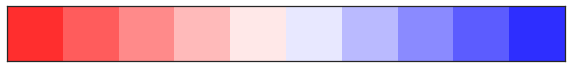

In [2]:
s = sns.color_palette("bwr_r", n_colors=10)
sns.palplot(s)

In [3]:
sns.__version__

'0.9.1'

In [4]:
from chembench import dataset
data = dataset.load_BACE()

total samples: 1513


In [5]:
df = data.df
df_feature_imp = pd.read_csv('./feature_importance.csv', index_col = 'v')

In [6]:
X = extractor.batch_transform(df.smiles)
dfx = pd.DataFrame(X, columns = extractor.bitsinfo.IDs)*1
dfx.index = df.smiles
weight = 'Feature importance based on training set'

100%|##########| 1513/1513 [00:11<00:00, 136.53it/s]


In [7]:
from molmap.feature.fingerprint import smarts_maccskey, smarts_pharmacophore, smarts_pubchem

smt1 = smarts_pubchem.smartsPatts
smt2 = smarts_maccskey.smartsPatts

_, bits = molmap.feature.fingerprint.pharmErGfp.GetPharmacoErGFPs(Chem.MolFromSmiles('C'), return_bitInfo=True)
erg = pd.DataFrame([bits]).T
erg.index = ['PharmacoErGFP%s' % i for i in erg.index]

smt3 = erg[0].to_dict()

smt3_map = smarts_pharmacophore.pharmacophore_smarts

In [8]:
smarts_all = []
for fp, s in df_feature_imp.iterrows():
    
    if s.Subtypes == 'PubChemFP':
        smarts = smt1.get(fp)
        
    if s.Subtypes == 'MACCSFP':
        smarts = smt2.get(fp)
        
    if s.Subtypes == 'PharmacoErGFP':
        smarts = smt3.get(fp)
    
    smarts_all.append(smarts)
    
df_feature_imp['smarts'] = smarts_all
df_map = df_feature_imp
df_map = df_map.dropna()

In [9]:
df_map.head(5)

,Feature importance based on training set,Feature importance based on test set,Subtypes,colors,x,y,Bit Substructure,Proportion in inhibitors,Proportion in non-inhibitors,smarts
v,,,,,,,,,,
PubChemFP797,0.051609,0.073840,PubChemFP,#d600ff,13,29,CC1CC(C)CCC1,0.687410,0.480535,"([#6][#6]1[#6][#6]([#6])[#6][#6][#6]1, 0)"
PubChemFP734,0.047897,0.085498,PubChemFP,#d600ff,16,31,Cc1cc(C)ccc1,0.683068,0.464720,"([#6]c1cc([#6])ccc1, 0)"
PharmacoErGFP148,0.046328,0.062735,PharmacoErGFP,#003fff,5,29,"('Acceptor', 'Positive', 2)",0.739508,0.485401,"(Acceptor, Positive, 2)"
MACCSFP84,0.044342,0.042815,MACCSFP,#00c7ff,9,31,"('[NH2]', 0)",0.953690,0.811436,"([NH2], 0)"
PharmacoErGFP24,0.039897,0.042800,PharmacoErGFP,#003fff,10,30,"('Donor', 'Acceptor', 4)",0.986975,0.880779,"(Donor, Acceptor, 4)"


In [351]:
def hit_bonds_from_atoms(mol, patt, hit_ats):

    bond_lists = []
    for i, hit_at in enumerate(hit_ats):
        hit_at = list(hit_at)
        bond_list = []
        for bond in patt.GetBonds():
            a1 = hit_at[bond.GetBeginAtomIdx()]
            a2 = hit_at[bond.GetEndAtomIdx()]
            bond_list.append(mol.GetBondBetweenAtoms(a1, a2).GetIdx())
        bond_lists.append(bond_list)
    return bond_lists


def _apply_mean(g): 
    """
    average to atom & bond's contribution
    """
    color_weight = g.color_weight.mean()
    radius_weight = g.radius_weight.mean()
    return radius_weight, color_weight


def _apply_scale(x, vmin, vmax):
    """
    scale to 0,1 (the same level)
    """
    #vmin= 0.008 #0.006
    #vmax= 0.06 #0.021
    return (x - vmin)/(vmax - vmin)


def value2color(values, vmin, vmax, cmap):
#     norm = DivergingNorm(vmin=values.min(), vcenter = values.mean(), vmax=values.max())
#     v = norm(values)
    v = _apply_scale(values, vmin, vmax)
    weighted_colors = [matplotlib.colors.to_rgb(i) for i in cmap(v)]
    return weighted_colors


def plot_fp(fp , i = 0):
    a = dfx[[fp]]
    a['y'] = df['Class'].tolist()
    a = a[a.y==1]
    m = a[a[fp]==1].index[i]
    mol = Chem.MolFromSmiles(m)

    if "MACCSFP" in fp:
        smt, count = smt2.get(fp)
    if "PubChemFP" in fp:
        smt, count = smt1.get(fp)

    patt = Chem.MolFromSmarts(smt)
    hit_ats = mol.GetSubstructMatches(patt)
    
    bond_lists = hit_bonds_from_atoms(mol, patt, hit_ats)

    colours = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]
    atom_cols = {}
    bond_cols = {}
    atom_list = []
    bond_list = []
    for i, (hit_atom, hit_bond) in enumerate(zip(hit_ats, bond_lists)):
        hit_atom = list(hit_atom)
        for at in hit_atom:
            atom_cols[at] = colours[1]
            atom_list.append(at)
        for bd in hit_bond:
            bond_cols[bd] = colours[1]
            bond_list.append(bd)
        

    d = rdMolDraw2D.MolDraw2DSVG(300, 300)
    
    rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=atom_list,
                                       highlightAtomColors=atom_cols,
                                       highlightBonds=bond_list, 
                                       highlightBondColors=bond_cols)

    d.FinishDrawing()

    svg = d.GetDrawingText()
    
    
    return svg, hit_ats, bimg, patt, mol


def highlight_important_atom(smiles, cmap, core_mol = None, vmin = 0.007, vmax = 0.025, top = 50, ):
    
    """
    #smiles = 'O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C'
    cmap: mpl color map
    core_smiles: core to align the molecule
    top: number of the top fingerprint to highlight, if -1, use all of it
    """
    X = extractor.transform(smiles)
    dfx = pd.DataFrame(X, index = extractor.bitsinfo.IDs, columns = [smiles])*1
    dfxs = dfx.T[df_map.index]

    ## make alignment
    mol = Chem.MolFromSmiles(smiles)
    
    if core_mol != None:
        AllChem.Compute2DCoords(core_mol)
        AllChem.GenerateDepictionMatching2DStructure(mol, core_mol)

    bits = dfxs.loc[smiles].to_frame(name = 'onbit').join(df_map)
    onbits = bits[bits['onbit']==1]

    all_hit = {}
    for fp, series in onbits.iterrows():

        color_weight = series[weight]

        if series.Subtypes == 'PharmacoErGFP':
            #continue
            radius_weight = 0.2
            p1, p2, erg_p = series.smarts
            
            hit_ats = []
            hit_bonds = []
            
            # point-1
            p1_hit_ats = []
            p1_hit_bonds = []
            for smt in smt3_map.get(p1):
                patt = Chem.MolFromSmarts(smt)
                hit_at = mol.GetSubstructMatches(patt)
                hit_bond = hit_bonds_from_atoms(mol, patt, hit_at)   
                p1_hit_ats.extend(hit_at)
                p1_hit_bonds.extend(hit_bond)
                
            # point-2
            p2_hit_ats = []
            p2_hit_bonds = []
            for smt in smt3_map.get(p2):
                patt = Chem.MolFromSmarts(smt)
                hit_at = mol.GetSubstructMatches(patt)
                hit_bond = hit_bonds_from_atoms(mol, patt, hit_at)   
                p2_hit_ats.extend(hit_at)
                p2_hit_bonds.extend(hit_bond)
            
            if (len(p1_hit_ats) > 0) & (len(p2_hit_ats) > 0):
                flag = False
                for i in p1_hit_ats:
                    for j in p2_hit_ats:
                        for k in i:
                            for l in j:
                                v = abs(k-l)
                                if v==erg_p:
                                    flag = True
                                    break
                if flag:
                    hit_ats.extend(p1_hit_ats)                
                    hit_bonds.extend(p1_hit_bonds)
                    hit_ats.extend(p2_hit_ats)                
                    hit_bonds.extend(p2_hit_bonds) 
            else:
                hit_ats = []
                hit_bonds = []
 
                    
            #remove duplicates
            atbd = pd.DataFrame([hit_ats, hit_bonds]).T.drop_duplicates(0)
            hit_ats = atbd[0].tolist()
            hit_bonds = atbd[1].tolist()  
        else:
            smarts = series.smarts[0]
            try:
                patt = Chem.MolFromSmarts(smarts)
                hit_ats = list(mol.GetSubstructMatches(patt))
                hit_bonds = hit_bonds_from_atoms(mol, patt, hit_ats)
            except:
                hit_ats = []
                hit_bonds = []

            radius_weight = 0.2

        all_hit[fp] = {"smarts":series.smarts,
                       'color_weight': color_weight,
                       'radius_weight': radius_weight, 
                       "hit_ats":hit_ats, 
                       "hit_bonds":hit_bonds }


    res = pd.Series(all_hit).apply(pd.Series)
    res = res.iloc[:top]

    
    unstack_res_atom = []
    unstack_res_bond = []

    for fp, hits in res.iterrows():

        color_weight = hits.color_weight
        radius_weight = hits.radius_weight
        #print(fp, radius_weight)
        for hit_atom, hit_bond in zip(hits.hit_ats, hits.hit_bonds):

            for at in hit_atom:
                unstack_res_atom.append({'color_weight':color_weight, 
                                    'radius_weight':radius_weight,
                                    'atom':at})
            for bd in hit_bond:
                unstack_res_bond.append({'color_weight':color_weight, 
                                    'radius_weight':radius_weight,
                                    'bond':bd})

    
    dfres_atom = pd.DataFrame(unstack_res_atom)
    dfres_bond = pd.DataFrame(unstack_res_bond)

    atoms = dfres_atom.groupby('atom').apply(_apply_mean).apply(pd.Series)
    atoms.columns = ['radii', 'color']
    print(atoms.color.min(), atoms.color.max())

    atoms.color = value2color(atoms.color.values, vmin, vmax, cmap)

    atom_list = atoms.index.tolist()
    atom_cols = atoms.color.to_dict()
    atom_radis = atoms.radii.to_dict()

    bonds = dfres_bond.groupby('bond').apply(_apply_mean).apply(pd.Series)
    bonds.columns = ['radii', 'color']
    print(bonds.color.min(), bonds.color.max())
    
    bonds.color = value2color(bonds.color.values, vmin, vmax, cmap)
    bond_cols = bonds.color.to_dict()
    bond_list = bonds.index.tolist()

    d = rdMolDraw2D.MolDraw2DCairo(500, 500)
    rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=atom_list,
                                       highlightAtomColors=atom_cols,
                                       highlightBonds=bond_list, 
                                       highlightAtomRadii = atom_radis,
                                       highlightBondColors=bond_cols
                                      )

    bimg = d.GetDrawingText()
    d = rdMolDraw2D.MolDraw2DSVG(300, 300)
    rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=atom_list,
                                       highlightAtomColors=atom_cols,
                                       highlightBonds=bond_list, 
                                       highlightBondColors=bond_cols)

    d.FinishDrawing()
    svg = d.GetDrawingText()
    
    return bimg, svg, bits

## 01. define min,max and draw colorbar

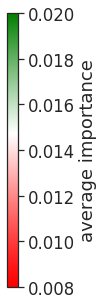

In [437]:
top = 50

vmin = 0.008 #df_map[weight].iloc[:top].min() 
vmax = 0.02 #df_map[weight].iloc[:top].max()

fig, ax = plt.subplots(figsize=(0.2, 10))
fig.subplots_adjust(bottom=0.5)


norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["red", "white","green"], N = 1000, gamma = 1.2)
#cmap = mpl.cm.cool

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm, #orientation='horizontal'
                                )
cb1.set_label('average importance')
fig.show()
fig.savefig('./cbar.svg', bbox_inches = 'tight')

## 01) clinical drugs https://www.nature.com/articles/nrd.2017.43/tables/1


In [670]:
dfd = pd.read_csv('../data/drugs_predict_all.csv')
dfd.head(5)

,smiles,status,name,company,Reference,MMNF,DMPNN,AttentiveFP
0,CN1C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(F)cn3)ccc2F)...,Phase III (discontinued),Verubecestat,Merck & Co.,PMID: 28248932,0.772816,0.583139,0.435961
1,CC1OCC2(c3cc(NC(=O)c4cnc(C(F)F)cn4)ccc3F)N=C(N...,Phase III (discontinued),Elenbecestat,Biogen/Eisai,PMID: 28248932,0.813703,0.164422,0.875178
2,CC#Cc1cncc(-c2ccc3c(c2)[C@@]2(N=C(C)C(N)=N2)[C...,Phase III (discontinued),Lanabecestat,AstraZeneca/Eli Lilly,PMID: 28248932,0.804224,0.835589,0.515956
3,CC1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)C=CSC(N)=N1,Phase III (discontinued),Atabecestat,Johnson & Johnson,PMID: 28248932,0.930097,0.854885,0.896908
4,CC1(c2nc(NC(=O)c3ncc(C(F)(F)F)cc3Cl)ccc2F)COC(...,Phase III (discontinued),Umibecestat,Novartis,PMID: 28248932,0.830551,0.680630,0.947785


In [673]:
# s = [0, 1, 2]
# dfb = dfd[dfd.index.isin(s)].reset_index(drop=True)
# dfb = dfb.sort_values('MMNF', ascending=False).reset_index(drop=True)
# dfb

dfb = dfd.head(5)

In [642]:
sms = ['CC(=O)Nc1ccc(F)cc1', 'CC#Cc1cncc(C)c1', 'CC(=O)Nc1ccc(F)cc1']


In [675]:
for i in dfb.index:

    s = dfb.iloc[i]
    
    print(i, s.smiles)
    if i == 2:
        core =Chem.MolFromSmiles('CC#Cc1cccnc1')
    else:
        core = Chem.MolFromSmiles('CNC(C)=O')

    ids = "drugs-%s-%s-%s" % (i, s['name'],s.MMNF.round(3))
    bimg, svg, bits = highlight_important_atom(s.smiles, cmap, core_mol = core, vmin = vmin, vmax =  vmax, top = top)
    display.Image(bimg)
    with open('./drugs/%s.svg' % ids , 'w') as f:
        f.write(svg)

0 CN1C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(F)cn3)ccc2F)CS1(=O)=O


RDKit ERROR: [11:53:28] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [11:53:28] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.014907901104099938 0.02575445592240813
0.013876956613919078 0.027596720749842304
1 CC1OCC2(c3cc(NC(=O)c4cnc(C(F)F)cn4)ccc3F)N=C(N)SCC12


RDKit ERROR: [11:53:28] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [11:53:28] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.015123778084945952 0.03053674379518556
0.013876956613919078 0.0463282408317347
2 CC#Cc1cncc(-c2ccc3c(c2)[C@@]2(N=C(C)C(N)=N2)[C@]2(CC[C@H](OC)CC2)C3)c1


RDKit ERROR: [11:53:29] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [11:53:29] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.013202512807908054 0.029667149241477314
0.011047134606424877 0.029667149241477314
3 CC1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)C=CSC(N)=N1


RDKit ERROR: [11:53:30] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [11:53:30] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.014149732041747742 0.02604331555104424
0.012393131189183948 0.0463282408317347
4 CC1(c2nc(NC(=O)c3ncc(C(F)(F)F)cc3Cl)ccc2F)COC(C)(C(F)(F)F)C(N)=N1


RDKit ERROR: [11:53:30] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [11:53:30] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.014581232672578392 0.02506815315545576
0.011078534154740971 0.028084115200163223


In [648]:
dfb = dfd.sort_values('MMNF', ascending=False).tail(3)
dfb.index = [5,6,7]
dfb

,smiles,status,name,company,Reference,MMNF,DMPNN,AttentiveFP
5,NC1=N[C@@](c2cccc(-c3cncnc3)c2)(c2ccnc(C(F)F)c...,Phase II (discontinued),AZD-3839,AstraZeneca,NCT01348737,0.538670,0.399974,0.880999
6,CC1(C#Cc2cnc3c(c2)[C@]2(COC(N)=N2)c2cc(-c4cccn...,Preclinical,AMG-8718,Amgen,CDDI database,0.501595,0.629554,0.854456
7,CC(C)Oc1cc(CN2CC[C@@]3(C[C@@H]2C)CN(C)S(=O)(=O...,Preclinical,PF-04976081,Pfizer,CDDI database,0.444775,0.064321,0.245601


In [665]:
dfb.smiles.tolist()

['NC1=N[C@@](c2cccc(-c3cncnc3)c2)(c2ccnc(C(F)F)c2)c2cccc(F)c21',
 'CC1(C#Cc2cnc3c(c2)[C@]2(COC(N)=N2)c2cc(-c4cccnc4F)ccc2O3)COC1',
 'CC(C)Oc1cc(CN2CC[C@@]3(C[C@@H]2C)CN(C)S(=O)(=O)N3c2cccc(F)c2)ccc1O']

In [669]:
for i in dfb.index:
    s = dfb.loc[i]
    print(i, s.smiles)
    if i==6:
        core = Chem.MolFromSmiles('Fc1ncccc1-c1ccccc1')
        
    elif i == 7:
        core = Chem.MolFromSmiles('C[C@H]1C[C@@]2(CN(C)S(=O)(=O)N2C)CCN1C')
    else:
        core = None
    ids = "drugs-%s-%s-%s" % (i, s['name'],s.MMNF.round(3))
    bimg, svg, bits = highlight_important_atom(s.smiles, cmap, core_mol = core, vmin = vmin, vmax =  vmax, top = top)
    display.Image(bimg)
    with open('./drugs/%s.svg' % ids , 'w') as f:
        f.write(svg)

5 NC1=N[C@@](c2cccc(-c3cncnc3)c2)(c2ccnc(C(F)F)c2)c2cccc(F)c21


RDKit ERROR: [11:44:57] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [11:44:57] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.011512459925229646 0.022022100284796
0.01090930576444882 0.02340466704593358
6 CC1(C#Cc2cnc3c(c2)[C@]2(COC(N)=N2)c2cc(-c4cccnc4F)ccc2O3)COC1


RDKit ERROR: [11:44:58] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [11:44:58] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.010189220470410931 0.028028834894672804
0.010189220470410931 0.031606204394147186
7 CC(C)Oc1cc(CN2CC[C@@]3(C[C@@H]2C)CN(C)S(=O)(=O)N3c2cccc(F)c2)ccc1O


RDKit ERROR: [11:44:59] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [11:44:59] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.010189220470410931 0.02007250997846234
0.010148504714139575 0.0215638291129532


## 02.draw scaffold-1

In [358]:
dfs = pd.read_csv('../data/scaffold_1.csv')
core = Chem.MolFromSmiles('Cc1ccccc1-c1ccc2nc(N)ccc2c1')
for i in dfs.index[:5]:
    s = dfs.iloc[i]
    ids = "scaffold1-%s-%s-%s" % (i, s.ID, s.pIC50.round(3))
    bimg, svg, bits = highlight_important_atom(s.smiles, cmap, core_mol = core, vmin = vmin, vmax =  vmax, top = top)
    display.Image(bimg)
    with open('./scaffold1/%s.svg' % ids , 'w') as f:
        f.write(svg)
        
core = Chem.MolFromSmiles('CCn1c(N)nc2cc(Cl)ccc12')
for i in dfs.index[5:]:
    s = dfs.iloc[i]
    ids = "scaffold1-%s-%s-%s" % (i, s.ID, s.pIC50.round(3))
    bimg, svg, bits = highlight_important_atom(s.smiles, cmap, core_mol = core, vmin = vmin, vmax =  vmax, top = top)
    display.Image(bimg)
    with open('./scaffold1/%s.svg' % ids , 'w') as f:
        f.write(svg)

## 03.draw non-inhibitors

In [803]:
dfs = pd.read_csv('../data/non-inhibitors.csv')


In [794]:
dfs = pd.read_csv('../data/non-inhibitors.csv')

for i in dfs.index:
    s = dfs.iloc[i]
    core = Chem.MolFromSmiles(s.scaffold)
    #print(i)

    ids = "scaffold2-%s-%s-%s-%s" % (s.group, i, s.ID, s.pIC50.round(3))
    bimg, svg, bits = highlight_important_atom(s.smiles, cmap, core_mol = core, vmin = vmin, vmax =  vmax, top = top)
    display.Image(bimg)
    with open('./non_inhibitor/%s.svg' % ids , 'w') as f:
        f.write(svg)

RDKit ERROR: [17:14:28] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [17:14:28] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.011344225998033355 0.023878065004419483
0.008187872597712975 0.022073765711576005


RDKit ERROR: [17:14:29] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [17:14:29] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.00941446066141553 0.023878065004419483
0.007693249692520804 0.022073765711576005


RDKit ERROR: [17:14:30] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [17:14:30] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.009529341995214506 0.023878065004419483
0.007693249692520804 0.022073765711576005


RDKit ERROR: [17:14:30] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [17:14:30] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.010775164960381334 0.023878065004419483
0.008187872597712975 0.022073765711576005


RDKit ERROR: [17:14:31] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [17:14:31] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.007682499577282864 0.023878065004419483
0.006724542877968795 0.022073765711576005


RDKit ERROR: [17:14:32] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [17:14:32] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.009748631728536928 0.028765229379382057
0.007249605418991056 0.0463282408317347


RDKit ERROR: [17:14:33] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [17:14:33] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.00913733225091776 0.0463282408317347
0.007970909859185582 0.0463282408317347


RDKit ERROR: [17:14:34] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [17:14:34] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.009322257982607843 0.025190167296681443
0.005380074393359191 0.019015797626431758


RDKit ERROR: [17:14:35] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [17:14:35] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.005647100828307066 0.023878065004419483
0.0047919360081946916 0.022073765711576005


RDKit ERROR: [17:14:35] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [17:14:35] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.0047212479785200085 0.014920171206280187
0.0047919360081946916 0.015507047457763323


RDKit ERROR: [17:14:36] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [17:14:36] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.009039040458723419 0.02007250997846234
0.009039040458723419 0.019918789632554945


RDKit ERROR: [17:14:37] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [17:14:37] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.008430549049002395 0.02007250997846234
0.008430549049002395 0.019918789632554945


RDKit ERROR: [17:14:38] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [17:14:38] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.00853370801778508 0.02007250997846234
0.00853370801778508 0.019918789632554945


RDKit ERROR: [17:14:39] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [17:14:39] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.008119669253601136 0.02007250997846234
0.009039040458723419 0.019918789632554945


RDKit ERROR: [17:14:40] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [17:14:40] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.008326688635693108 0.02007250997846234
0.00853370801778508 0.019918789632554945


## 04.draw inhibitors

In [806]:
dfs = pd.read_csv('../data/inhibitors.csv')
dfs

,smiles,ID,Class,pIC50,group,scaffold
0,Fc1ncccc1-c1cc(ccc1)C1(N=C(N)N(C)C1=O)c1cn(nc1...,BACE_464,1,7.795880,1,CN1C(N)=NC(C)(C1=O)c1cccc(C)c1
1,Clc1cc(ccc1OC)C1(N=C(N)N(C)C1=O)c1cc(ccc1)-c1c...,BACE_627,1,7.443698,1,CN1C(N)=NC(C)(C1=O)c1cccc(C)c1
2,Fc1c(cccc1F)-c1cc(ccc1)C1(N=C(N)N(C)C1=O)c1ccncc1,BACE_646,1,7.397940,1,CN1C(N)=NC(C)(C1=O)c1cccc(C)c1
3,O(CCC)c1cc(ccc1OC)C1(N=C(N)N(C)C1=O)c1cc(ccc1)...,BACE_689,1,7.301030,1,CN1C(N)=NC(C)(C1=O)c1cccc(C)c1
4,Fc1ncccc1-c1cc(ccc1)C1(N=C(N)N(C)C1=O)c1cn(nc1...,BACE_699,1,7.301030,1,CN1C(N)=NC(C)(C1=O)c1cccc(C)c1
5,FC1(F)COC(=NC1(C)c1cc(NC(=O)c2ncc(OCC#CC)nc2)c...,BACE_350,1,8.221849,2,CC(=O)Nc1ccc(F)c(C)c1
6,Clc1ccc(nc1)C(=O)Nc1cc(C2(N=C(N)N(CC2)C)C)c(F)cc1,BACE_433,1,7.920819,2,CC(=O)Nc1ccc(F)c(C)c1
7,Fc1ccc(NC(=O)c2ncc(cc2)C#N)cc1[C@]1(N=C(O[C@H]...,BACE_40,1,7.886056,2,CC(=O)Nc1ccc(F)c(C)c1
8,Clc1ccc(nc1)C(=O)Nc1cc(C2(N=C(N)C(=O)N(C2)C)C)...,BACE_657,1,7.397940,2,CC(=O)Nc1ccc(F)c(C)c1
9,Clc1cc(Cl)cnc1C(=O)Nc1cc(C2(N=C(N)COC2)C)c(F)cc1,BACE_672,1,7.346787,2,CC(=O)Nc1ccc(F)c(C)c1


In [807]:
dfs = pd.read_csv('../data/inhibitors.csv')

for i in dfs.index:
    s = dfs.iloc[i]
    core = Chem.MolFromSmiles(s.scaffold)
    print(i)

    ids = "scaffold-%s-%s-%s-%s" % (s.group, i, s.ID, s.pIC50.round(3))
    bimg, svg, bits = highlight_important_atom(s.smiles, cmap, core_mol = core, vmin = vmin, vmax =  vmax, top = top)
    display.Image(bimg)
    with open('./inhibitor/%s.svg' % ids , 'w') as f:
        f.write(svg)

0


RDKit ERROR: [19:35:15] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [19:35:15] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.016361475004506687 0.027830145552211766
0.01406875449172143 0.02672857046874878
1


RDKit ERROR: [19:35:15] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [19:35:15] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.01500495627891918 0.03138253080703352
0.01406875449172143 0.029438985577276477
2


RDKit ERROR: [19:35:16] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [19:35:16] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.014951281569831477 0.02646952892104279
0.012766615425251916 0.022069926267539786
3


RDKit ERROR: [19:35:17] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [19:35:17] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.014232912041519406 0.03138253080703352
0.012489030128085124 0.029438985577276477
4


RDKit ERROR: [19:35:18] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [19:35:18] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.016003443702501174 0.02930648776542735
0.01406875449172143 0.029438985577276477
5


RDKit ERROR: [19:35:18] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [19:35:18] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.014853390888743934 0.026045811994231078
0.013876956613919078 0.023169634816608886
6


RDKit ERROR: [19:35:19] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [19:35:19] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.014907901104099938 0.027272400628539955
0.013876956613919078 0.029431823933362855
7


RDKit ERROR: [19:35:20] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [19:35:20] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.015067561766913295 0.024642884382596535
0.013876956613919078 0.02710527871764978
8


RDKit ERROR: [19:35:20] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [19:35:20] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.014907901104099938 0.02629092877898572
0.013876956613919078 0.03026938332155278
9


RDKit ERROR: [19:35:21] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [19:35:21] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.012965962521742452 0.03143425805354042
0.011078534154740971 0.03143425805354042
10


RDKit ERROR: [19:35:21] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [19:35:21] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.014907901104099938 0.02533956266765498
0.013876956613919078 0.021989777668372984
11


RDKit ERROR: [19:35:22] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [19:35:22] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.014147952183712167 0.024215450009328548
0.013876956613919078 0.024215450009328548
12


RDKit ERROR: [19:35:23] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [19:35:23] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.015515133021998279 0.023511554123209606
0.01406875449172143 0.021989777668372984
13


RDKit ERROR: [19:35:24] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [19:35:24] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.012467764742929335 0.022022100284796
0.01090930576444882 0.02340466704593358
14


RDKit ERROR: [19:35:25] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [19:35:25] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.012467764742929335 0.020594780066702043
0.01090930576444882 0.021989777668372984


# scaffold-21

In [749]:
dfs = pd.read_csv('../data/scaffold_21.csv')
dfs

,Unnamed: 0,smiles,ID,Class,pIC50
0,0,s1ccnc1-c1cc(ccc1)CC(NC(=O)C1OCCC1)C(O)C[NH2+]...,BACE_354,1,8.200660
1,1,Clc1ccc(cc1)CC(NC(=O)C)C(O)C[NH2+]C1CC2(Oc3ncc...,BACE_378,1,8.080922
2,2,s1c2OC(C[C@H]([NH2+]C[C@@H](O)[C@@H](NC(=O)C)C...,BACE_30,1,8.070581
3,3,Fc1c(cccc1C#C)CC(NC(=O)COC)C(O)C[NH2+]C1CC2(Oc...,BACE_427,1,7.958607
4,4,O=C(N[C@H]([C@H](O)C[NH2+][C@H]1CC(Cc2nn(cc12)...,BACE_71,1,7.356547
5,5,ClC1=CN=C(NC1=O)C(NC1=NC(Cc2c1ccc(Cl)c2)(C)C)C...,BACE_1045,0,6.251812
6,6,Clc1cc2CC([NH+]=C(N[C@@H](Cc3ccccc3)C3=NOC(=O)...,BACE_141,0,6.124939
7,7,O=C([O-])C(NC1=NC(Cc2c1ccc(c2)C)(C)C)Cc1ccccc1,BACE_1306,0,5.266803
8,8,Clc1cc2CC(N=C(NC(Cc3ccccc3)c3nc(ccn3)C)c2cc1)(C)C,BACE_1529,0,3.602060
9,9,Clc1cc2CC(N=C(NC(Cc3ccccc3)c3oc(nn3)C)c2cc1)(C)C,BACE_1533,0,3.468904


In [752]:
dfs.iloc[:5].smiles.tolist()

['s1ccnc1-c1cc(ccc1)CC(NC(=O)C1OCCC1)C(O)C[NH2+]C1CC2(Oc3ncc(cc13)CC(C)(C)C)CCC2',
 'Clc1ccc(cc1)CC(NC(=O)C)C(O)C[NH2+]C1CC2(Oc3ncc(cc13)CC(C)(C)C)CCC2',
 's1c2OC(C[C@H]([NH2+]C[C@@H](O)[C@@H](NC(=O)C)Cc3ccccc3)c2cc1CC(C)(C)C)(C)C',
 'Fc1c(cccc1C#C)CC(NC(=O)COC)C(O)C[NH2+]C1CC2(Oc3ncc(cc13)CC(C)(C)C)CCC2',
 'O=C(N[C@H]([C@H](O)C[NH2+][C@H]1CC(Cc2nn(cc12)CC(C)(C)C)(C)C)Cc1ccccc1)C']

In [754]:
for i in dfs.index[:5]:
    core = Chem.MolFromSmiles('CC(O)C(Cc1ccccc1)NC(C)=O')
    print(i)
    s = dfs.iloc[i]
    ids = "scaffold2-%s-%s-%s" % (i, s.ID, s.pIC50.round(3))
    bimg, svg, bits = highlight_important_atom(s.smiles, cmap, core_mol = core, vmin = vmin, vmax =  vmax, top = top)
    display.Image(bimg)
    with open('./scaffold21/%s.svg' % ids , 'w') as f:
        f.write(svg)

0


RDKit ERROR: [14:58:15] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [14:58:15] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.013448298628345054 0.024549687255616064
0.011832226005446334 0.027556391122532126
1


RDKit ERROR: [14:58:16] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [14:58:16] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.01341094832785844 0.023878065004419483
0.011832226005446334 0.022073765711576005
2


RDKit ERROR: [14:58:17] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [14:58:17] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.013591259466557945 0.01992974065134518
0.011338132639395482 0.020579108663407467
3


RDKit ERROR: [14:58:18] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [14:58:18] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.013906792322104441 0.02650823517829879
0.013591259466557945 0.027556391122532126
4


RDKit ERROR: [14:58:19] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [14:58:19] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.010549263117429875 0.019782524967317645
0.010189220470410931 0.02248048965505534


In [751]:
for i in dfs.index[5:]:
    core = Chem.MolFromSmiles('CC(Cc1ccccc1)NC1=NC(C)(C)Cc2ccccc12')
    print(i)
    s = dfs.iloc[i]
    ids = "scaffold2-%s-%s-%s" % (i, s.ID, s.pIC50.round(3))
    bimg, svg, bits = highlight_important_atom(s.smiles, cmap, core_mol = core, vmin = vmin, vmax =  vmax, top = top)
    display.Image(bimg)
    with open('./scaffold21/%s.svg' % ids , 'w') as f:
        f.write(svg)

5


RDKit ERROR: [14:54:04] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [14:54:04] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.011344225998033355 0.023878065004419483
0.008187872597712975 0.022073765711576005
6


RDKit ERROR: [14:54:05] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [14:54:05] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.00941446066141553 0.023878065004419483
0.007693249692520804 0.022073765711576005
7


RDKit ERROR: [14:54:06] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [14:54:06] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.009100453808667006 0.022791131010610026
0.007693249692520804 0.024568652607322248
8


RDKit ERROR: [14:54:07] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [14:54:07] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.007107105500652633 0.023878065004419483
0.006724542877968795 0.022073765711576005
9


RDKit ERROR: [14:54:08] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [14:54:08] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.010437397164269202 0.023878065004419483
0.007693249692520804 0.022073765711576005


In [755]:
dfs = pd.read_csv('../data/scaffold_22.csv')
dfs

,Unnamed: 0,smiles,ID,Class,pIC50
0,0,Brc1cc2c(cc1)C1(CCC2)C[NH2+]CC1C(=O)N1CCC(CC1C...,BACE_543,1,7.619789
1,1,Clc1nc2c(cc1)C1(CCC2)C[NH2+]CC1C(=O)N1CCC(CC1C...,BACE_576,1,7.537602
2,2,O=C(N1CCC(CC1C1CCCCC1)c1ccccc1)C1C[NH2+]CC12CC...,BACE_628,1,7.443698
3,3,Brc1ccccc1C1C[NH2+]CC1C(=O)N1CCC(CC1c1ccccc1)c...,BACE_1054,0,6.221849
4,4,Brc1ccccc1C1C[NH2+]CC1C(=O)N1CCC(CC1)c1ccccc1,BACE_1405,0,4.721246
5,5,O=C(N1CCC(CC1)c1ccccc1)C1C[NH2+]CC1c1ccccc1,BACE_1406,0,4.721246
6,6,Brc1ccccc1C1C[NH2+]CC1C(=O)N1CCCCC1c1ccccc1,BACE_1482,0,4.244125


In [756]:
dfs.iloc[3:].smiles.tolist()

['Brc1ccccc1C1C[NH2+]CC1C(=O)N1CCC(CC1c1ccccc1)c1ccccc1',
 'Brc1ccccc1C1C[NH2+]CC1C(=O)N1CCC(CC1)c1ccccc1',
 'O=C(N1CCC(CC1)c1ccccc1)C1C[NH2+]CC1c1ccccc1',
 'Brc1ccccc1C1C[NH2+]CC1C(=O)N1CCCCC1c1ccccc1']

In [757]:
for i in dfs.index[3:]:
    core = Chem.MolFromSmiles('O=C(C1C[NH2+]CC1c1ccccc1)N1CCCCC1')
    print(i)
    s = dfs.iloc[i]
    ids = "scaffold2-%s-%s-%s" % (i, s.ID, s.pIC50.round(3))
    bimg, svg, bits = highlight_important_atom(s.smiles, cmap, core_mol = core, vmin = vmin, vmax =  vmax, top = top)
    display.Image(bimg)
    with open('./scaffold22/%s.svg' % ids , 'w') as f:
        f.write(svg)

3


RDKit ERROR: [15:13:46] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [15:13:46] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.011475230530093394 0.02127616471385989
0.010072534689429572 0.019761603641161456
4


RDKit ERROR: [15:13:47] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [15:13:47] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.010803332369530204 0.02127616471385989
0.010001616145513976 0.019761603641161456
5


RDKit ERROR: [15:13:48] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [15:13:48] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.010167448880941106 0.017414415060130733
0.009504863223567707 0.019761603641161456
6


RDKit ERROR: [15:13:48] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [15:13:48] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.011004608882988685 0.02127616471385989
0.010072534689429572 0.019761603641161456


In [343]:
core = Chem.MolFromSmiles('CN1C(N)=NC(C1=O)(c1ccccc1)c1cccc(c1)-c1cccnc1')
#core = None
for i in dfs.index[5:]:
    s = dfs.iloc[i]
    ids = "scaffold2-%s-%s-%s" % (i, s.ID, s.pIC50.round(3))
    bimg, svg, bits = highlight_important_atom(s.smiles, cmap, core_mol = core, vmin = vmin, vmax =  vmax, top = top)
    display.Image(bimg)
    with open('./scaffold2/%s.svg' % ids , 'w') as f:
        f.write(svg)

RDKit ERROR: [20:50:30] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [20:50:30] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.01500495627891918 0.03138253080703352
0.01406875449172143 0.029438985577276477


RDKit ERROR: [20:50:32] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [20:50:32] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.01500495627891918 0.03138253080703352
0.01406875449172143 0.029438985577276477


RDKit ERROR: [20:50:33] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [20:50:33] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.014232912041519406 0.03138253080703352
0.012489030128085124 0.029438985577276477


RDKit ERROR: [20:50:35] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [20:50:35] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.014232912041519406 0.03138253080703352
0.012489030128085124 0.029438985577276477


RDKit ERROR: [20:50:37] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [20:50:37] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.014232912041519406 0.03138253080703352
0.012489030128085124 0.029438985577276477


# scaffold 3

In [369]:
dfs = pd.read_csv('../data/scaffold_3.csv')
dfs

,Unnamed: 0,smiles,ID,Class,pIC50
0,0,Clc1cc2CC([NH+]=C(N[C@@H](Cc3ccccc3)C3=NOC(=O)...,BACE_141,0,6.124939
1,6,ClC1=CN=C(NC1=O)C(NC1=NC(Cc2c1ccc(Cl)c2)(C)C)C...,BACE_1045,0,6.251812
2,7,Clc1cc2CC(N=C(NC(Cc3ccccc3)C=3NC(ON=3)=O)c2cc1...,BACE_1076,0,6.124939
3,8,Clc1cc2CC(N=C(NC(Cc3ccccc3)C=3NC(=O)C=CN=3)c2c...,BACE_1238,0,5.567031
4,9,Clc1cc2CC(N=C(NC(Cc3ccccc3)c3ncccn3)c2cc1)(C)C,BACE_1510,0,3.862963
5,1,Fc1ccc(cc1OC(F)(F)F)CC(NC(=O)C)C(O)C[NH2+]C1CC...,BACE_294,1,8.677781
6,2,Fc1cc(ccc1OC)CC(NC(=O)C)C(O)C[NH2+]C1CC2(Oc3nc...,BACE_317,1,8.443698
7,3,Fc1ccc(cc1C(F)(F)F)CC(NC(=O)C)C(O)C[NH2+]C1CC2...,BACE_418,1,7.958607
8,4,O1c2ncc(cc2C([NH2+]CC(O)C(NC(=O)C)Cc2cc(OC)c(O...,BACE_479,1,7.739929
9,5,FC(F)Oc1cc(ccc1OC(F)F)CC(NC(=O)C)C(O)C[NH2+]C1...,BACE_626,1,7.453457


In [370]:
core = Chem.MolFromSmiles('Clc1ccc2C(NCCc3ccccc3)=NCCc2c1')

for i in dfs.index[:5]:
    print(i)
    s = dfs.iloc[i]
    ids = "scaffold3-%s-%s-%s" % (i, s.ID, s.pIC50.round(3))
    bimg, svg, bits = highlight_important_atom(s.smiles, cmap, core_mol = core, vmin = vmin, vmax =  vmax, top = top)
    display.Image(bimg)
    with open('./scaffold3/%s.svg' % ids , 'w') as f:
        f.write(svg)

0


RDKit ERROR: [21:19:03] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [21:19:03] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.00941446066141553 0.023878065004419483
0.007693249692520804 0.022073765711576005
1


RDKit ERROR: [21:19:04] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [21:19:04] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.011344225998033355 0.023878065004419483
0.008187872597712975 0.022073765711576005
2


RDKit ERROR: [21:19:06] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [21:19:06] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.009529341995214506 0.023878065004419483
0.007693249692520804 0.022073765711576005
3


RDKit ERROR: [21:19:07] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [21:19:07] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.010775164960381334 0.023878065004419483
0.008187872597712975 0.022073765711576005
4


RDKit ERROR: [21:19:09] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [21:19:09] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.007682499577282864 0.023878065004419483
0.006724542877968795 0.022073765711576005


In [371]:
core = Chem.MolFromSmiles('CC(=O)NC(Cc1ccccc1)C(O)C[NH2+]C1CC2(CCC2)Oc2ncc(CC(C)(C)C)cc12')

for i in dfs.index[5:]:
    print(i)
    s = dfs.iloc[i]
    ids = "scaffold3-%s-%s-%s" % (i, s.ID, s.pIC50.round(3))
    bimg, svg, bits = highlight_important_atom(s.smiles, cmap, core_mol = core, vmin = vmin, vmax =  vmax, top = top)
    display.Image(bimg)
    with open('./scaffold3/%s.svg' % ids , 'w') as f:
        f.write(svg)

5


RDKit ERROR: [21:20:52] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [21:20:52] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.013591259466557945 0.02566688337925175
0.013591259466557945 0.030805890389365983
6


RDKit ERROR: [21:20:54] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [21:20:54] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.013591259466557945 0.023873323634472157
0.013591259466557945 0.02216879316926423
7


RDKit ERROR: [21:20:55] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [21:20:55] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.013591259466557945 0.025553318272757187
0.013591259466557945 0.029194616780298204
8


RDKit ERROR: [21:20:57] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [21:20:57] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.01341094832785844 0.020697944975385456
0.011832226005446334 0.022069926267539786
9


RDKit ERROR: [21:20:59] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [21:20:59] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.013591259466557945 0.024160347199913442
0.012336819732741958 0.02340466704593358


# One Smiles

In [ ]:
Clc1cc2nc(n(c2cc1)CCCC(=O)NC(C)C)N
Clc1cc2nc(n(c2cc1)CCCO)N


RDKit ERROR: [17:50:19] SMARTS Parse Error: syntax error while parsing: ?
RDKit ERROR: [17:50:19] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


0.016361475004506687 0.027830145552211766
0.01406875449172143 0.02672857046874878


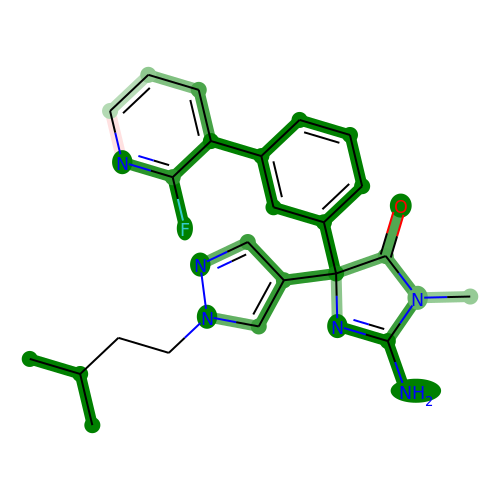

In [795]:
s = 'Fc1ncccc1-c1cc(ccc1)C1(N=C(N)N(C)C1=O)c1cn(nc1)CCC(C)C'
bimg, svg, bits = highlight_important_atom(s,cmap,  vmin = vmin,  vmax = vmax,  top = top)
display.Image(bimg)

In [44]:
smiles = "O=C(NCC1CCCCC1)CCc1cc2c(nc1N)cccc2" #"Clc1cc2nc(n(c2cc1)CCCC(=O)N(CC1CCCCC1)C)N"#"O=C(N(C)C1CCCCC1)CCc1cc2cc(ccc2nc1N)-c1ccccc1C"
# 
# smiles = "Clc1cc2nc(n(c2cc1)CCCC(=O)N(CC1CCCCC1)C)N"

# smiles = "O=C(N(C)C1CCCCC1)CCc1cc2cc(ccc2nc1N)-c1ccccc1C"

# smiles = "Clc1ccccc1-c1n(Cc2nc(N)ccc2)c(cc1)-c1ccc(Oc2cncnc2)cc1"
# smiles = "Clc1ccccc1-c1n(Cc2nc(N)ccc2)c(cc1)-c1ccc(Nc2cncnc2)cc1"

smiles = "O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C"
smiles = "O=C(NCCC(C)(C)C)C(Cc1cc2cc(ccc2nc1N)-c1ccccc1C)C"

## 01) Helogen Group

In [45]:
smt2.get("MACCSFP87")

('[F,Cl,Br,I]!@*@*', 0)

In [46]:
smt2.get("MACCSFP107")

('[F,Cl,Br,I]~*(~*)~*', 0)

In [47]:
smt2.get("MACCSFP134")

('[F,Cl,Br,I]', 0)

In [48]:
smt2.get("MACCSFP42")

('F', 0)

In [49]:
smt1.get("PubChemFP287")

('[#6]~[F]', 0)

In [50]:
smt1.get("PubChemFP364")

('[#6](~[F])(:c)', 0)

In [51]:
smt1.get("PubChemFP364")

('[#6](~[F])(:c)', 0)

In [52]:
smt1.get("PubChemFP363")

('[#6](~[F])(~[F])', 0)

## 02) Chalcogen group

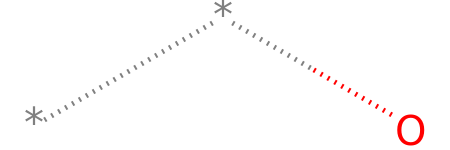

In [53]:
smt2.get("MACCSFP127")
smt2.get("MACCSFP143")
Chem.MolFromSmarts(smt2.get("MACCSFP143")[0])

## 03)Donor, Acceptor

In [54]:
smt2.get("MACCSFP53")

('[!#6;!#1;!H0]~*~*~*~[!#6;!#1;!H0]', 0)

In [55]:
smt2.get("MACCSFP84")

('[NH2]', 0)

In [56]:
smt2.get("MACCSFP131")

('[!#6;!#1;!H0]', 1)

In [57]:
smt1.get("PubChemFP16")

('[N]', 3)

In [58]:
smt3.get('PharmacoErGFP4')

('Donor', 'Donor', 5)

In [59]:
smt3.get('PharmacoErGFP5')

('Donor', 'Donor', 6)

In [60]:
smt3.get('PharmacoErGFP24')

('Donor', 'Acceptor', 4)

In [61]:
smt3.get('PharmacoErGFP26')

('Donor', 'Acceptor', 6)

In [62]:
smt3.get('PharmacoErGFP103')

('Donor', 'Hydrophobic', 20)

In [63]:
smt3.get('PharmacoErGFP104')

('Donor', 'Hydrophobic', 21)

In [64]:
smt3_map.get('Donor')

['[N;!H0;v3,v4&+1]', '[O,S;H1;+0]', '[n&H1&+0]']

In [65]:
smt3_map.get('Acceptor')

['[O,S;H1;v2;!$(*-*=[O,N,P,S])]',
 '[O;H0;v2]',
 '[O,S;v1;-]',
 '[N;v3;!$(N-*=[O,N,P,S])]',
 '[n&H0&+0]',
 '[o;+0;!$([o]:n);!$([o]:c:n)]']

## 04) Group4: Aromatic Ring

In [66]:
smt1.get("PubChemFP797")

('[#6][#6]1[#6][#6]([#6])[#6][#6][#6]1', 0)

In [67]:
smt1.get("PubChemFP696")

('[#6]-,:[#6]-,:[#6]-,:[#6]-,:[#6]-,:[#6]-,:[#6]-,:[#6]', 0)

In [68]:
smt1.get("PubChemFP697")

('[#6]-,:[#6]-,:[#6]-,:[#6]-,:[#6]-,:[#6](-,:[#6])-,:[#6]', 0)

In [69]:
smt1.get("PubChemFP712")

('[#6]-,:[#6](-,:[#6])-,:[#6](-,:[#6])-,:[#6]', 0)

In [70]:
smt1.get("PubChemFP734")

('[#6]c1cc([#6])ccc1', 0)

# 05) Group5: -N-O-

In [71]:
smt2.get("MACCSFP110")

('[#7]~[#6]~[#8]', 0)

In [72]:
smt2.get("MACCSFP92")

('[#8]~[#6](~[#7])~[#6]', 0)

In [73]:
smt1.get("PubChemFP536")

('[#8]=,:[#6]-,:[#6]-,:[#7]', 0)

In [74]:
smt1.get("PubChemFP451")

('[#6](-,:[#7])(=,:[#8])', 0)

In [75]:
smt2.get("MACCSFP154")

('[#6]=[#8]', 0)

In [76]:
smt1.get("PubChemFP420")

('[#6]=,:[#8]', 0)

In [77]:
smt1.get("PubChemFP439") #31, 29

('[#6](-,:[#6])(-,:[#7])(=,:[#8])', 0)

In [78]:
smt1.get("PubChemFP443") #32, 29

('[#6](-,:[#6])(=,:[#8])', 0)

In [79]:
smt1.get("PubChemFP579") #33, 28

('[#8]=,:[#6]-,:[#6]-,:[#6]-,:[#6]', 0)

In [80]:
smt1.get("PubChemFP685") #34, 28

('[#8]=,:[#6]-,:[#6]-,:[#6]-,:[#6]-,:[#7]', 0)

In [81]:
smt1.get("PubChemFP684") #34, 29

('[#8]=,:[#6]-,:[#6]-,:[#6]-,:[#6]-,:[#6]', 0)

In [82]:
smt1.get("PubChemFP692") #35, 29

('[#8]=,:[#6]-,:[#6]-,:[#6]-,:[#6]-,:[#6]-,:[#6]', 0)

In [83]:
smt1.get("PubChemFP704") #35, 30

('[#8]=,:[#6]-,:[#6]-,:[#6]-,:[#6]-,:[#6]-,:[#6]-,:[#6]', 0)

# 06) Group6: Phamarcophore

In [84]:
#smt3_map.get('Hydrophobic')

In [85]:
smt3.get('PharmacoErGFP286') #3, 32

('Positive', 'Hydrophobic', 14)

In [86]:
smt3.get('PharmacoErGFP144') #3, 33

('Acceptor', 'Acceptor', 19)

In [87]:
smt3.get('PharmacoErGFP287') #4, 30

('Positive', 'Hydrophobic', 15)

In [88]:
smt3.get('PharmacoErGFP283') #4, 34

('Positive', 'Hydrophobic', 11)

In [89]:
smt3.get('PharmacoErGFP149') #5, 26

('Acceptor', 'Positive', 3)

In [90]:
smt3.get('PharmacoErGFP289') #5, 27

('Positive', 'Hydrophobic', 17)

In [91]:
smt3.get('PharmacoErGFP148') #5, 29

('Acceptor', 'Positive', 2)

In [92]:
smt3.get('PharmacoErGFP146') #5, 31

('Acceptor', 'Acceptor', 21)

In [93]:
smt3.get('PharmacoErGFP44') #6, 32

('Donor', 'Positive', 3)

In [94]:
smt3.get('PharmacoErGFP42') #7, 33

('Donor', 'Positive', 1)

In [95]:
smt3.get('PharmacoErGFP41') #7, 34

('Donor', 'Acceptor', 21)

In [96]:
Donor = ["[N;!H0;v3,v4&+1]", "[O,S;H1;+0]", "[n&H1&+0]"]


Acceptor = ["[O,S;H1;v2;!$(*-*=[O,N,P,S])]",  "[O;H0;v2]", "[O,S;v1;-]", 
            "[N;v3;!$(N-*=[O,N,P,S])]", "[n&H0&+0]", "[o;+0;!$([o]:n);!$([o]:c:n)]"]


Positive = ["[#7;+]", "[N;H2&+0][$([C,a]);!$([C,a](=O))]", 
            "[N;H1&+0]([$([C,a]);!$([C,a](=O))])[$([C,a]);!$([C,a](=O))]", 
            "[N;H0&+0]([C;!$(C(=O))])([C;!$(C(=O))])[C;!$(C(=O))]"]

Negative = ["[C,S](=[O,S,P])-[O;H1,-1]"]

Hydrophobic = ["[C;D3,D4](-[CH3])-[CH3]", "[S;D2](-C)-C"]

Aromatic = ["a"]

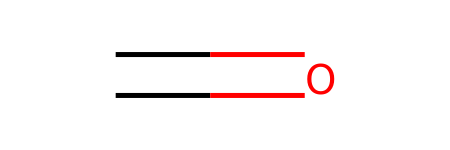

In [97]:
Chem.MolFromSmarts('[#6]=[#8]')

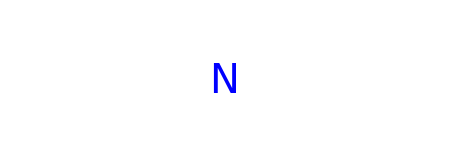

In [98]:
Chem.MolFromSmarts(smt3_map.get('Positive')[0])

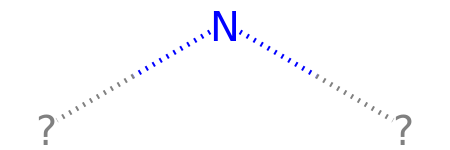

In [99]:
Chem.MolFromSmarts(smt3_map.get('Positive')[2])

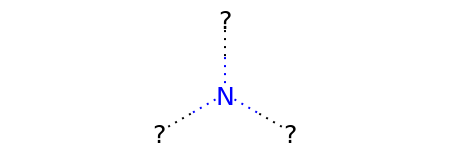

In [100]:
Chem.MolFromSmarts(smt3_map.get('Positive')[3])

In [101]:
fp = "MACCSFP127" #,"PubChemFP734"
svg, hit_ats, bimg, patt, mol = plot_fp(fp, i = -10)
with open('./%s.svg' % fp , 'w') as f:
    f.write(svg)

/home/sxh/anaconda3/envs/rdkit2020/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
